# Obraz - transfer learning - praca domowa
Ostatnia aktualizacja: 2023.04.29

Uwaga: praca jest jednoosobowa. 

Z dokumentacji [Keras](https://keras.io/guides/transfer_learning/): *Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.*

Głównym celem pracy domowej jest stworzenie klasyfikatora, który będzie odróżniał zdjęcia obiektów w wybranym przez nas zbiorze. Użyjemy do tego jednego z [gotowych modeli Keras](https://keras.io/api/applications/), wytrenowanego wcześniej na zbiorze Imagenet. 

Przydatne źródła:
- [transfer learning vgg16 + tf_flowers](https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4)
- [Keras - transfer learning](https://keras.io/guides/transfer_learning/)

### Wybierz swój zbiór danych### 
Chcemy mieć co najmniej 2-3 klasy. Możesz użyć gotowego zbioru (np. z [katalogu tensorflow](https://www.tensorflow.org/datasets/catalog/overview) lub [kaggle](https://www.kaggle.com/datasets)) albo użyć własnych danych. 
- [Przykładowy zbiór: tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers). 
- [Przykładowy zbiór: plant_leaves](https://www.tensorflow.org/datasets/catalog/plant_leaves). 

Wczytaj i przygotuj dane do treningu. 



In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [3]:
data, info = tfds.load('beans', as_supervised=True, with_info=True)
data

{'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(500, 500, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'validation': <_PrefetchDataset element_spec=(TensorSpec(shape=(500, 500, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'test': <_PrefetchDataset element_spec=(TensorSpec(shape=(500, 500, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [4]:
info

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_path='C:\\Users\\Urszula\\tensorflow_datasets\\beans\\0.1.0',
    file_format=tfrecord,
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
      

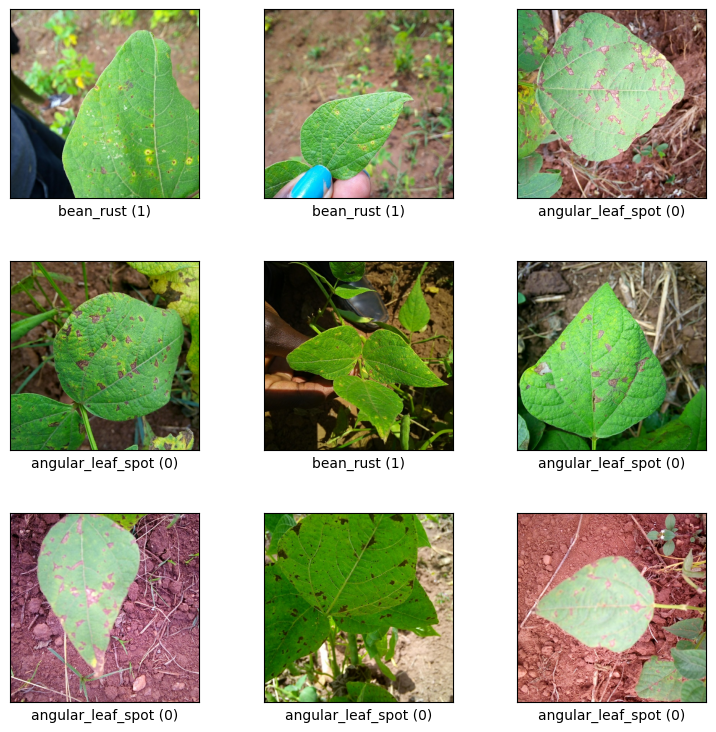

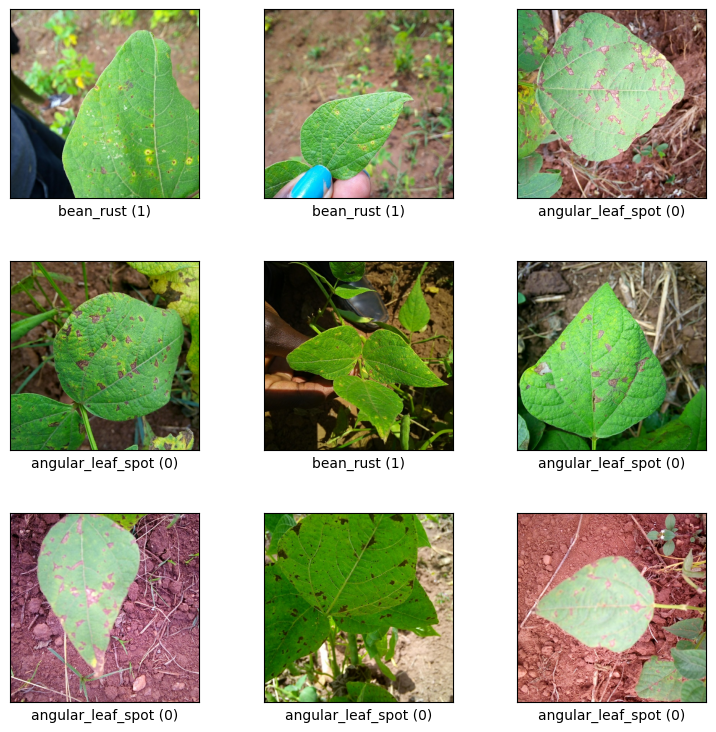

In [5]:
tfds.show_examples(data['train'], info)

In [6]:
for image, label in data['train'].take(5):
  print(image.shape, label)

(500, 500, 3) tf.Tensor(1, shape=(), dtype=int64)
(500, 500, 3) tf.Tensor(1, shape=(), dtype=int64)
(500, 500, 3) tf.Tensor(0, shape=(), dtype=int64)
(500, 500, 3) tf.Tensor(0, shape=(), dtype=int64)
(500, 500, 3) tf.Tensor(1, shape=(), dtype=int64)


In [7]:
del data

In [8]:
(training_images, training_labels), (test_images, test_labels) = \
tfds.as_numpy(tfds.load('beans', split = ['train', 'test'], 
batch_size=-1, as_supervised=True))

In [9]:
training_images = training_images / 255.0
test_images = test_images / 255.0

In [10]:
training_images.shape

(1034, 500, 500, 3)

In [11]:
1034*0.2

206.8

In [12]:
test_images.shape

(128, 500, 500, 3)

In [13]:
training_labels = tf.keras.utils.to_categorical(training_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [14]:
training_labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

### Wczytaj wytrenowany model do klasyfikacji obrazu. ###
Może to być jeden z gotowych [modeli dostępnych w Keras](https://keras.io/api/applications/). Wczytujemy go z wytrenowanymi już wcześniej wagami na Imagenecie (weights='imagenet'). 

Model możemy wczytać bez ostatnich warstw (include_top=False) i dodać je potem ręcznie, dostosowane do liczby klas w naszym zbiorze. Imagenet ma 1000 klas, my prawdopodobnie będziemy mieć ich mniej. 

Pamiętaj, żeby wyłączyć lub ograniczyć trening części modelu z wytrenowanymi już wagami (trainable=False). 

In [15]:
model1 = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(500, 500, 3))
model1.trainable = False

In [16]:
model1.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 506, 506, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 250, 250, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

### Zadanie 1: Wytrenuj model na swoich danych ###
**(Zadanie na ocenę 3)**

Wytrenuj wybrany model na swoich danych. Omów eksperyment i wyniki (100-150 słów). 

In [17]:
inputs = tf.keras.Input(shape = (500, 500, 3))

x = model1(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(3, activation = "softmax")(x)

model1 = tf.keras.Model(inputs, outputs)

In [18]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 resnet101 (Functional)      (None, 16, 16, 2048)      42658176  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 42,664,323
Trainable params: 6,147
Non-trainable params: 42,658,176
_________________________________________________________________


In [19]:
model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

In [20]:
history1 = model1.fit(tf.keras.applications.resnet.preprocess_input(training_images), training_labels, epochs = 20, validation_split=0.2)

Epoch 1/20
26/26 [==============================] - 193s 7s/step - loss: 1.1083 - accuracy: 0.3785 - val_loss: 1.0618 - val_accuracy: 0.4155
Epoch 2/20
26/26 [==============================] - 194s 8s/step - loss: 1.1039 - accuracy: 0.3773 - val_loss: 1.0544 - val_accuracy: 0.4734
Epoch 3/20
26/26 [==============================] - 197s 8s/step - loss: 1.0763 - accuracy: 0.4244 - val_loss: 1.0614 - val_accuracy: 0.5024
Epoch 4/20
26/26 [==============================] - 191s 7s/step - loss: 1.0666 - accuracy: 0.4184 - val_loss: 1.0891 - val_accuracy: 0.4106
Epoch 5/20
26/26 [==============================] - 190s 7s/step - loss: 1.0545 - accuracy: 0.4196 - val_loss: 1.0965 - val_accuracy: 0.3382
Epoch 6/20
26/26 [==============================] - 192s 7s/step - loss: 1.0586 - accuracy: 0.4281 - val_loss: 1.0350 - val_accuracy: 0.4203
Epoch 7/20
26/26 [==============================] - 188s 7s/step - loss: 1.0403 - accuracy: 0.4559 - val_loss: 1.0636 - val_accuracy: 0.4493
Epoch 8/20
26

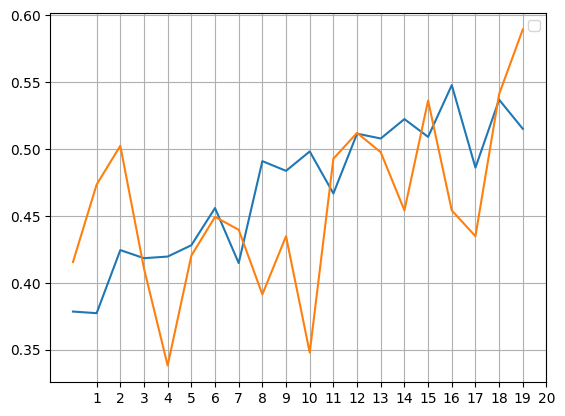

In [24]:
import matplotlib.pyplot as plt
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.xticks(range(1, 21))
plt.grid(True)
plt.legend()
plt.show()

In [25]:
model1.evaluate(tf.keras.applications.resnet.preprocess_input(test_images), test_labels)

4/4 [==============================] - 23s 6s/step - loss: 0.9792 - accuracy: 0.6016


[0.9791960716247559, 0.6015625]

*TODO: omówienie (100-150 słów)*

Ogólnie przez 20 epok model bardzo powoli poprawił accuracy o paręnaście punktów procentowych, jednak nie jest zbyt skuteczny. Widać to zwłaszcza w początkowych epokach na zbiorze walidacyjnym. Możliwe że więcej epok albo zmiana parametrów nieco polepszyłyby wyniki. Jednak Imagenet na którym był trenowany resnet zawiera raczej inne kategorie obiektów (zwierzęta, codzienne przedmioty, owoce, itp.) a nie tak jak wybrany zbior liście konkretnych roślin, więc takie wyniki nie powinny dziwić.

### Zadanie 2: Dodatkowe sieci ###
**(Zadanie na ocenę 4, po wykonaniu  zadania 1)**

Przeprowadź to samo na dwóch dodatkowych sieciach i omów wyniki (50-100 słów). 

Czyli jeśli w zadaniu 1 użyliśmy np. VGG to teraz wybieramy sobie np. ResNet i MobileNet. 

In [26]:
model2 = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(500, 500, 3))
model2.trainable = False

17225924/17225924 [==============================] - 5s 0us/step


In [27]:
inputs = tf.keras.Input(shape = (500, 500, 3))

x = model2(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(3, activation = "softmax")(x)

model2 = tf.keras.Model(inputs, outputs)

model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 15, 15, 1024)     3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 3,231,939
Trainable params: 3,075
Non-trainable params: 3,228,864
_________________________________________________________________


In [28]:
model2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])
history2 = model2.fit(tf.keras.applications.mobilenet.preprocess_input(training_images), training_labels, epochs = 20, validation_split=0.2)

Epoch 1/20
26/26 [==============================] - 28s 1s/step - loss: 1.1938 - accuracy: 0.3422 - val_loss: 1.1244 - val_accuracy: 0.3237
Epoch 2/20
26/26 [==============================] - 27s 1s/step - loss: 1.1077 - accuracy: 0.3229 - val_loss: 1.0853 - val_accuracy: 0.3285
Epoch 3/20
26/26 [==============================] - 26s 1s/step - loss: 1.0876 - accuracy: 0.4087 - val_loss: 1.1046 - val_accuracy: 0.4541
Epoch 4/20
26/26 [==============================] - 26s 1s/step - loss: 1.0812 - accuracy: 0.3954 - val_loss: 1.0782 - val_accuracy: 0.3720
Epoch 5/20
26/26 [==============================] - 27s 1s/step - loss: 1.0841 - accuracy: 0.3809 - val_loss: 1.0569 - val_accuracy: 0.4589
Epoch 6/20
26/26 [==============================] - 28s 1s/step - loss: 1.0578 - accuracy: 0.4547 - val_loss: 1.0405 - val_accuracy: 0.4783
Epoch 7/20
26/26 [==============================] - 28s 1s/step - loss: 1.0548 - accuracy: 0.4341 - val_loss: 1.0345 - val_accuracy: 0.4348
Epoch 8/20
26/26 [==

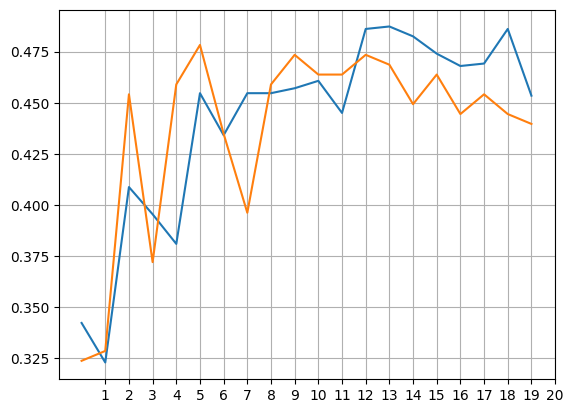

In [29]:
# import matplotlib.pyplot as plt
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.xticks(range(1, 21))
plt.grid(True)
plt.show()

In [30]:
model2.evaluate(tf.keras.applications.mobilenet.preprocess_input(test_images), test_labels)

4/4 [==============================] - 3s 854ms/step - loss: 1.0105 - accuracy: 0.4688


[1.010528802871704, 0.46875]

In [31]:
model3 = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(500, 500, 3))
model3.trainable = False

29084464/29084464 [==============================] - 10s 0us/step


In [32]:
inputs = tf.keras.Input(shape=(500, 500, 3))
x = model3(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

model3 = tf.keras.Model(inputs, outputs)

model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 15, 15, 1024)      7037504   
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
_________________________________________________________________


In [33]:
model3.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=tf.keras.losses.CategoricalCrossentropy(),
               metrics=["accuracy"])
history3 = model3.fit(tf.keras.applications.densenet.preprocess_input(training_images), training_labels, epochs=20, validation_split=0.2)

Epoch 1/20
26/26 [==============================] - 119s 4s/step - loss: 1.1438 - accuracy: 0.3374 - val_loss: 1.1069 - val_accuracy: 0.3527
Epoch 2/20
26/26 [==============================] - 112s 4s/step - loss: 1.1090 - accuracy: 0.3374 - val_loss: 1.1030 - val_accuracy: 0.3527
Epoch 3/20
26/26 [==============================] - 111s 4s/step - loss: 1.1099 - accuracy: 0.3313 - val_loss: 1.1045 - val_accuracy: 0.3527
Epoch 4/20
26/26 [==============================] - 111s 4s/step - loss: 1.1187 - accuracy: 0.3180 - val_loss: 1.1005 - val_accuracy: 0.3527
Epoch 5/20
26/26 [==============================] - 110s 4s/step - loss: 1.1065 - accuracy: 0.3180 - val_loss: 1.1060 - val_accuracy: 0.3527
Epoch 6/20
26/26 [==============================] - 109s 4s/step - loss: 1.1160 - accuracy: 0.3204 - val_loss: 1.1098 - val_accuracy: 0.3237
Epoch 7/20
26/26 [==============================] - 109s 4s/step - loss: 1.1069 - accuracy: 0.3555 - val_loss: 1.1143 - val_accuracy: 0.3237
Epoch 8/20
26

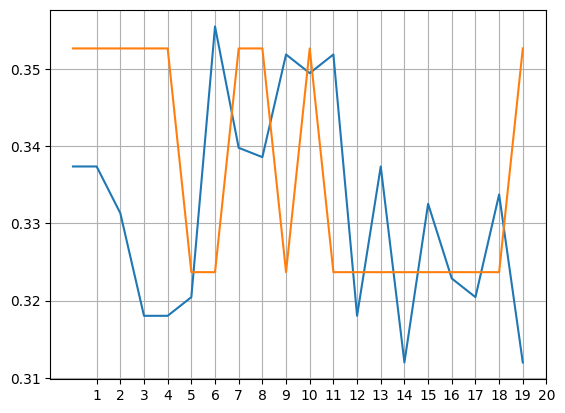

In [34]:
# import matplotlib.pyplot as plt

plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.xticks(range(1, 21))
plt.grid(True)
plt.show()

In [35]:
model3.evaluate(tf.keras.applications.densenet.preprocess_input(test_images), test_labels)

4/4 [==============================] - 13s 3s/step - loss: 1.1032 - accuracy: 0.3359


[1.1032488346099854, 0.3359375]

*TODO: omówienie (50-100 słów)*

Mobilenet radzie sobie gorzej niż resnet, chociaż w ciągu treningu accuracy nieco wzrosło i być może udałoby się je jeszcze polepszyć. Za to densenet zupełnie nie uczy się odróżniania tych 3 klas.
Oprócz tego, że jak w powyższym przypadku modele były tworzone do innych zastosowań, dochodzi tutaj jeszcze fakt, że wybrany zbiór danych zawiera tak naprawdę 3 "odmiany" tego samego obiektu - liścia fasoli. Być może udałoby się jednak użyć mobilenetu do stworzenia np. bazy do mobilnego narzędzia do rozpoznawania roślin?

### Zadanie 3: Trening od zera i porównanie ###
**(Zadanie na ocenę 5, po wykonaniu zadania 1 i 2)**

Spróbuj skonstruować swój własny model i wytrenować go 'od zera' na tych samych danych. Porównaj i omów swój ekeperyment i wyniki (100-150 słów).

In [36]:
inputs = tf.keras.Input(shape = (500, 500, 3))

hidden = tf.keras.layers.Conv2D(filters = 32, kernel_size = 8, activation = "relu")(inputs)
hidden = tf.keras.layers.AveragePooling2D(pool_size = 2)(hidden)
hidden = tf.keras.layers.Conv2D(filters = 64, kernel_size = 8, activation = "relu")(hidden)
hidden = tf.keras.layers.AveragePooling2D(pool_size = 2)(hidden)
hidden = tf.keras.layers.Conv2D(filters = 128, kernel_size = 4, activation = "relu")(hidden)
hidden = tf.keras.layers.AveragePooling2D(pool_size = 2)(hidden)
hidden = tf.keras.layers.Flatten()(hidden)

outputs = tf.keras.layers.Dense(3, activation = "softmax")(hidden)

model4 = tf.keras.Model(inputs = inputs, outputs = outputs)
model4.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=tf.keras.losses.CategoricalCrossentropy(),
               metrics=["accuracy"])
history4 = model4.fit(training_images, training_labels, epochs=20, validation_split=0.2)

Epoch 1/20
26/26 [==============================] - 175s 7s/step - loss: 4.9341 - accuracy: 0.3180 - val_loss: 1.0992 - val_accuracy: 0.3237
Epoch 2/20
26/26 [==============================] - 173s 7s/step - loss: 1.0987 - accuracy: 0.3398 - val_loss: 1.0991 - val_accuracy: 0.3237
Epoch 3/20
26/26 [==============================] - 173s 7s/step - loss: 1.0986 - accuracy: 0.3398 - val_loss: 1.0993 - val_accuracy: 0.3237
Epoch 4/20
26/26 [==============================] - 174s 7s/step - loss: 1.0986 - accuracy: 0.3398 - val_loss: 1.0993 - val_accuracy: 0.3237
Epoch 5/20
26/26 [==============================] - 174s 7s/step - loss: 1.0988 - accuracy: 0.3398 - val_loss: 1.0995 - val_accuracy: 0.3237
Epoch 6/20
26/26 [==============================] - 173s 7s/step - loss: 1.0987 - accuracy: 0.3398 - val_loss: 1.0991 - val_accuracy: 0.3237
Epoch 7/20
26/26 [==============================] - 173s 7s/step - loss: 1.0988 - accuracy: 0.3398 - val_loss: 1.0990 - val_accuracy: 0.3237
Epoch 8/20
26

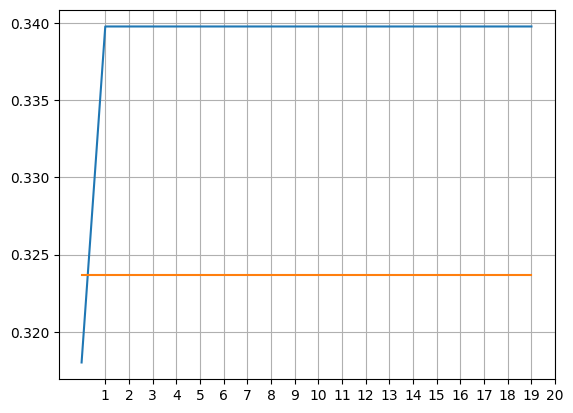

In [37]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.xticks(range(1, 21))
plt.grid(True)
plt.show()

In [38]:
model4.evaluate(test_images, test_labels)

4/4 [==============================] - 5s 1s/step - loss: 1.0986 - accuracy: 0.3359


[1.098613977432251, 0.3359375]

*TODO: omówienie (100-150 słów)*
Tutaj wyniki są dość rozczarowujące, bo podobną sieć wykorzystywałam w innym projekcie z rozpoznawamiem guzów mógu (tam jednak obrazy były czarno-białe, tu kolorowe, oprócz tego w zdjęciach fasoli jest więcej innych elementów, np. jaskrawo pomalowane paznokcie osoby trzymającej liść, jakość zdjęć też wydaje się bardziej zróżnicowana - czasem zdjęcia są jaśniejsze).
Ogólnie eksperymenty w tym zadaniu pokazują, że próby klasyfikacji "odmian" jednego typu obiektu mogą być dość trudne, wymagają dobrej jakości zbioru danych i odpowiedniego podejścia do reprezentacji tych obrazów (RGB vs. czarno-białe). Zbiór był też relatywnie mały, a ograniczone zasoby obliczeniowe nie pozwalały na zbyt długi trening, próby bardziej zaawansowanej regularyzacji, ani stworzenie bardziej rozbudowanych sieci od zera. Ciekawym podejściem byłoby też zastosowanie dwóch modeli - jednego wykrywającego liść na zdjęciu i drugiego dokonującego właściwej klasyfikacji na tym ograniczonym fragmencie.

To wszystko, dziękuję. Wypełniony notatnik zapisz jako .ipynb i oddaj w Teams. 